# HW Instructions

In this exercise, you will be working with the ViT model for image classification using the CIFAR10 dataset. 

The task will involve going through the full machine learning lifecycle, including: preprocessing and exploratory data analysis, model implementation and training, tuning, and evaluation. 

It is assumed that you have some prior experience in the field from previous assignments. This assignment allows for flexibility in exploring and implementing solutions as you see fit.
Make sure you read the instructions carefully.

In [1]:
# feel free to add any imports you might need (as long as it is part of the course environment)
import torch
import pandas as pd
import torchvision
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models.vision_transformer import Encoder

In [2]:
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data Loading

In [3]:
# define transforms
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean and std of the dataset

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean and std of the dataset


train_dataset = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform) # download the dataset
test_dataset = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform) # download the dataset

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# this is a list of the class names
label_names = train_dataset.classes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Plotting 10 images in 1 rows and 10 cols


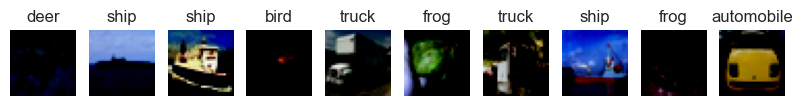

In [5]:
#############################################################################
# TO DO:                                                                    #
# plot a couple of images with their corresponding labels                   #
#############################################################################

# helper function to plot n images with their labels
def plot_n_images(images, labels):
    n = len(images)
    num_images = len(images)
    num_cols = n
    num_rows = num_images // num_cols
    print(f'Plotting {num_images} images in {num_rows} rows and {num_cols} cols')
    fig, axes = plt.subplots(1, n, figsize=(10, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].permute(1, 2, 0))
        current_label_name = label_names[labels[i]]
        ax.set_title(current_label_name)
        ax.axis('off')
    plt.show()


# plot 10 random images from the train dataset
random_indices = np.random.randint(0, len(test_dataset), 10)
images = [train_dataset[i][0] for i in random_indices]
labels = [train_dataset[i][1] for i in random_indices]
plot_n_images(images, labels)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## A bit of exploratory data analysis (EDA)

In [6]:
print(train_dataset.__dict__.keys())

def eda(dataset):
    num_samples = len(dataset)
    num_labels = len(dataset.classes)
    num_samples_per_label = [0] * num_labels
    for i in range(num_samples):
        label = dataset[i][1]
        num_samples_per_label[label] += 1
    return num_samples, num_labels, num_samples_per_label

def plot_eda(num_samples_per_label):
    plt.bar(label_names, num_samples_per_label)
    plt.xticks(rotation=90)
    plt.show()


dict_keys(['root', 'transform', 'target_transform', 'transforms', 'train', 'data', 'targets', 'classes', 'class_to_idx'])


Number of samples in train: 50000
Number of labels in train: 10
Number of samples per label in train: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
Number of samples in test: 10000
Number of labels in test: 10
Number of samples per label in test: [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


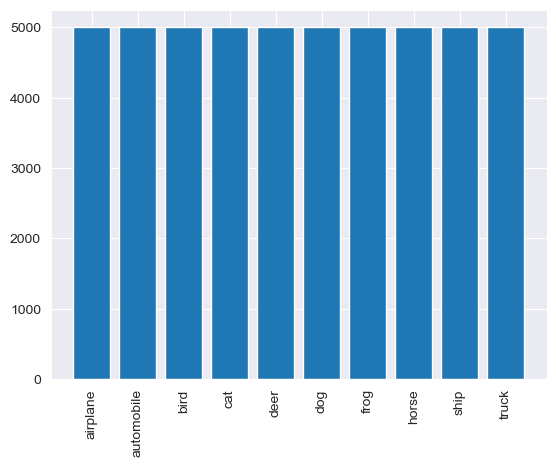

In [7]:
#############################################################################
# TO DO:                                                                    #
# Figure out the size of the dataset:                                       #
# How many samples in train/test?                                            #
# How many labels? How many samples per label?                              #
# Try access train_dataset.__dict__.keys() to see which attributes          #
# are available on train_dataset.                                           #
#############################################################################

num_samples_train, num_labels_train, num_samples_per_label_train = eda(train_dataset)
num_samples_test, num_labels_test, num_samples_per_label_test = eda(test_dataset)

print(f'Number of samples in train: {num_samples_train}')
print(f'Number of labels in train: {num_labels_train}')
print(f'Number of samples per label in train: {num_samples_per_label_train}')

print(f'Number of samples in test: {num_samples_test}')
print(f'Number of labels in test: {num_labels_test}')
print(f'Number of samples per label in test: {num_samples_per_label_test}')

# plot eda
plot_eda(num_samples_per_label_train)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Create DataLoaders

In [8]:
#############################################################################
# TO DO:                                                                    #
# Decide on a batch size (which later can be tunned)                        #
#############################################################################

batch_size = 64

# create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

# Building ViT Model

In the next section, you will construct a Vision Transformer, a transformer-based image classifier. The goal of the ViT model is to bring advancements from the natural language processing field to computer vision. 

For this exercise, you will be required to implement the ViT model using a pre-built Encoder from the PyTorch library. Building the encoder can be challenging, so we have eliminated that step for you. If you are not familiar with the ViT model, it is highly recommended that you gain an understanding of its workings before beginning implementation. There is a ton of information available online, here is a pretty informative source:
https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline

In this assignment, you will be using a pre-built Encoder from the PyTorch library, which has already been loaded in the provided code. Therefore, you do not need to worry about the complexities of transformer computations when referring to the link provided.

In [9]:
from torchvision.models.vision_transformer import Encoder

# Vit (Vision Transformer) model, used for image classification.
class ViT(nn.Module):
    # flow of the model:
    # 1. image -> patch embedding (convolution). in_dim = 3 , out_dim = hidden_dim
    # 2. patch embedding -> positional embedding (linear). in_dim = hidden_dim, out_dim = hidden_dim
    # 3. positional embedding -> transformer encoder (multi-head attention). in_dim = hidden_dim, out_dim = hidden_dim
    # 4. transformer encoder -> MLP (fully connected). in_dim = hidden_dim, out_dim = hidden_dim
    # 5. MLP -> output (fully connected). in_dim = hidden_dim, out_dim = num_classes

    def __init__(self, image_size, patch_size, num_classes, num_layers, num_heads,
                 hidden_dim, mlp_dim, dropout, attention_dropout):
        super().__init__()
        
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the required layers for your ViT model implementation.           #
        # Hint: For the curious among us, you can pick at pytorch's                 #
        # official implementation of vit (vit_b_16).                                #
        #############################################################################

        # initializing the patch embedding, each patch
        self.patch_embedding = nn.Conv2d(in_channels=3, out_channels=hidden_dim, kernel_size=patch_size, stride=patch_size)

        # initializing the positional embedding
        seq_length = (image_size // patch_size) ** 2
        self.positional_embedding = nn.Linear(seq_length, hidden_dim)

        # initializing the encoder backbone, transformer encoder
        # you should calculate the seq_length
        self.encoder = Encoder(
        seq_length=seq_length,
        num_layers=num_layers,
        num_heads=num_heads,
        hidden_dim=hidden_dim,
        mlp_dim=mlp_dim,
        dropout=dropout,
        attention_dropout=attention_dropout
        )

        # initializing the MLP=Multi-Layer Perceptron, in_dim = hidden_dim, out_dim = hidden_dim
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, mlp_dim), # fully connected layer
            nn.GELU(), # activation function
            nn.Dropout(dropout), # dropout
            nn.Linear(mlp_dim, hidden_dim), # fully connected layer
            nn.Dropout(dropout) # dropout
        )

        # initializing the output layer
        self.output = nn.Linear(hidden_dim, num_classes)

        # initializing the device, use GPU if available
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

        #############################################################################
        # TO DO:                                                                    #
        # Complete the rest of the class (foward method and other helper            #
        # functions if needed).                                                     #
        #############################################################################

    def get_embedding(self, x):
        # x: (batch_size, 3, image_size, image_size)

        # 1. image -> patch embedding (convolution)
        x = self.patch_embedding(x) # (batch_size, hidden_dim, image_size/patch_size, image_size/patch_size)

        # 2. patch embedding -> positional embedding (linear)
        x = x.flatten(2).transpose(1, 2) # (batch_size, image_size/patch_size * image_size/patch_size, hidden_dim)
        x = self.positional_embedding(x) # (batch_size, image_size/patch_size * image_size/patch_size, hidden_dim)

        return x

    def get_output(self, x):
        # x: (batch_size, image_size/patch_size * image_size/patch_size, hidden_dim)

        # 3. positional embedding -> transformer encoder (multi-head attention)
        x = self.encoder(x) # (batch_size, image_size/patch_size * image_size/patch_size, hidden_dim)

        # 4. transformer encoder -> MLP (fully connected)
        x = self.mlp(x) # (batch_size, image_size/patch_size * image_size/patch_size, hidden_dim)

        # 5. MLP -> output (fully connected)
        x = self.output(x) # (batch_size, image_size/patch_size * image_size/patch_size, num_classes)

        # output
        x = x.mean(dim=1) # (batch_size, num_classes)

        return x

    def forward(self, x):
        # x: (batch_size, 3, image_size, image_size)

        # 1. image -> patch embedding (convolution)
        # 2. patch embedding -> positional embedding (linear)
        x = self.get_embedding(x)

        # 3. positional embedding -> transformer encoder (multi-head attention)
        # 4. transformer encoder -> MLP (fully connected)
        # 5. MLP -> output (fully connected)
        x = self.get_output(x)

        return x

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

In [10]:
# this is just a simple initialization, feel free to change it.
model = ViT(image_size=32, patch_size=4, num_classes=10, num_layers=2, num_heads=2, hidden_dim=64,
                 mlp_dim=512, dropout=0.25, attention_dropout=0.1)
model.to(device)

# print number of parameters
print("Number of learnable parameters: ", sum(p.numel() for p in model.parameters() if p.requires_grad))

Number of learnable parameters:  244298


In [11]:
# Load the saved model, if you have one (delete/write # in the lower line)

#model.load_state_dict(torch.load('model.ckpt'))

# Training

## IMPORTANT READ!

In the following section, you will be required to train your implementation of the ViT model as in previous assignments. However, it is important to note that training transformers can be challenging, especially when starting from scratch, as is the case in this exercise.

It is acceptable if your final model does not achieve a high accuracy score, but it is crucial to document your training experiments and demonstrate that the model is able to train correctly (i.e. the loss decreases over time). This includes noting what you tried, what parameters worked best, and providing the loss and accuracy graphs as instructed in the next sections.

A reference for training ViT on CIFAR10 can be found at https://github.com/omihub777/ViT-CIFAR. However, it's important to note that in the provided reference, the ViT model was trained using 200 epochs and over 2 hours of training.

Note 1: If the loss decreases and your model trains correctly, you are on the safe side. The focus should be on the experiments and the things you tried.

Note 2: The main goal is not to achieve a high accuracy score but to demonstrate that you understand the process.

Note 3: If your final model's performance is strictly better than a random model (accuracy of around 1/num_classes) and you have provided thorough documentation of your experiments and processes, you will receive full credit for the assignment. 

In [12]:
#############################################################################
# TO DO:                                                                    #
# Create a validation set from the training set
# Implement the training loop
# Save the loss and accuracy for both training/validation sets every couple of iterations for plotting afterwards.
#############################################################################

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# split the training set into training and validation sets
train_set_size = int(0.8 * len(train_dataset))
val_set_size = len(train_dataset) - train_set_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size])

In [13]:
# Hyperparameters
num_epochs = 15
learning_rate = 1e-3
batch_size = 64

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)

In [14]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
val_loss_list = []
val_acc_list = []

# Training loop
for epoch in range(num_epochs):
    # load a batch of images with its (index, data, class)
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backward and optimize
        optimizer.zero_grad() # clear the gradients of all optimized variables
        loss.backward() # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step() # perform a single optimization step (parameter update)

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                           (correct / total) * 100))

    # Validation loop, once per epoch
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_list.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_acc_list.append(correct / total)
        print('Validation accuracy is: {} %'.format((correct / total) * 100))

Epoch [1/15], Step [100/625], Loss: 1.9734, Accuracy: 32.81%
Epoch [1/15], Step [200/625], Loss: 1.9411, Accuracy: 21.88%
Epoch [1/15], Step [300/625], Loss: 1.8925, Accuracy: 34.38%
Epoch [1/15], Step [400/625], Loss: 1.7252, Accuracy: 43.75%
Epoch [1/15], Step [500/625], Loss: 1.6496, Accuracy: 40.62%
Epoch [1/15], Step [600/625], Loss: 1.6284, Accuracy: 32.81%
Validation accuracy is: 36.32 %
Epoch [2/15], Step [100/625], Loss: 1.6628, Accuracy: 29.69%
Epoch [2/15], Step [200/625], Loss: 1.6489, Accuracy: 37.50%
Epoch [2/15], Step [300/625], Loss: 1.5118, Accuracy: 51.56%
Epoch [2/15], Step [400/625], Loss: 1.7434, Accuracy: 35.94%
Epoch [2/15], Step [500/625], Loss: 1.5377, Accuracy: 43.75%
Epoch [2/15], Step [600/625], Loss: 1.5441, Accuracy: 51.56%
Validation accuracy is: 43.16 %
Epoch [3/15], Step [100/625], Loss: 1.5460, Accuracy: 35.94%
Epoch [3/15], Step [200/625], Loss: 1.6163, Accuracy: 37.50%
Epoch [3/15], Step [300/625], Loss: 1.3643, Accuracy: 45.31%
Epoch [3/15], Step [4

In [43]:
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Loss and Acurracy

In [44]:
# Plot 2 graphs:
# Graph 1: Loss vs iteration for training and validation sets
# Graph 2: Accuracy vs iteration for training and validation sets

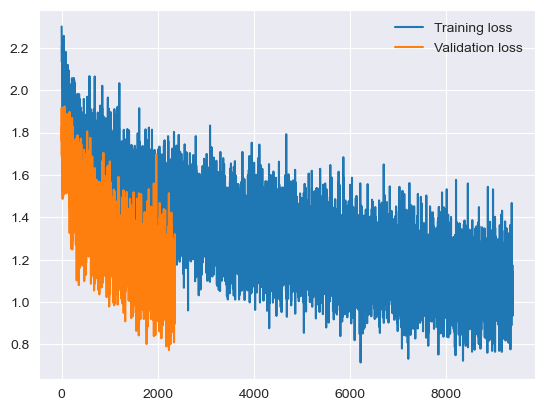

In [45]:
# Graph 1, loss vs iteration training
plt.plot(loss_list, label='Training loss')
plt.plot(val_loss_list, label='Validation loss')
plt.legend(frameon=False)
plt.show()

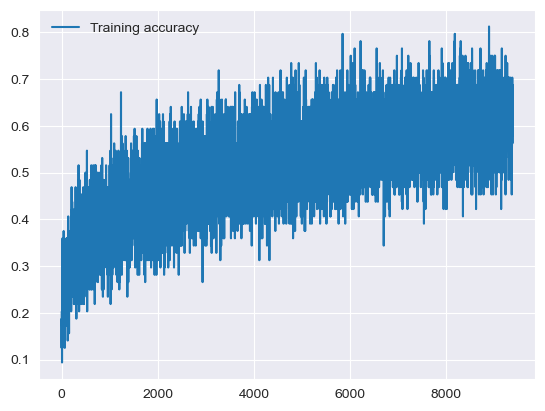

In [46]:
# Graph 2, accuracy vs iteration training
plt.plot(acc_list, label='Training accuracy')
plt.legend(frameon=False)
plt.show()

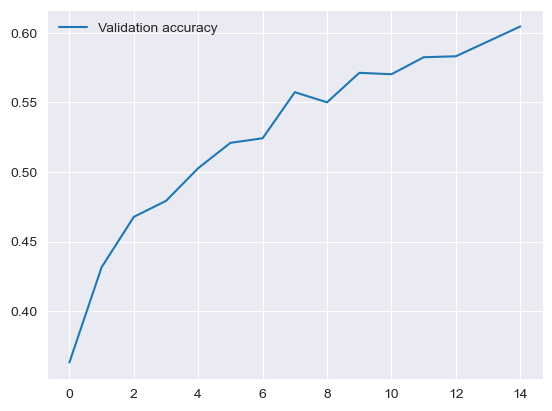

In [47]:
# Graph 2, accuracy vs iteration validation
plt.plot(val_acc_list, label='Validation accuracy')
plt.legend(frameon=False)
plt.show()


# Evaluation 

In [48]:
# Calculate the accuracy of the final model on the test set.

# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()




    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

Test Accuracy of the model on the 10000 test images: 62.62 %


In [49]:
# save the model checkpoint, so you can load it later and use it for inference
torch.save(model.state_dict(), 'model.ckpt')

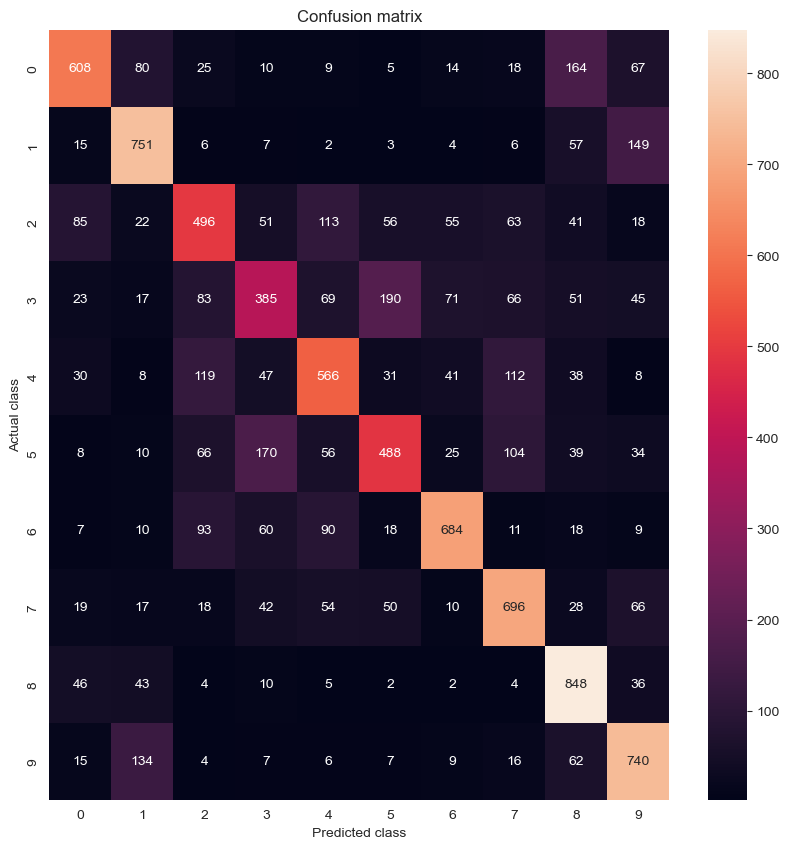

Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [50]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# get all predictions for the test set
test_predictions = torch.LongTensor()

with torch.no_grad():
    for i, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_predictions = torch.cat((test_predictions, predicted.to("cpu")), dim=0)

cm = confusion_matrix(test_dataset.targets, test_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

print("Classes: ", test_dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


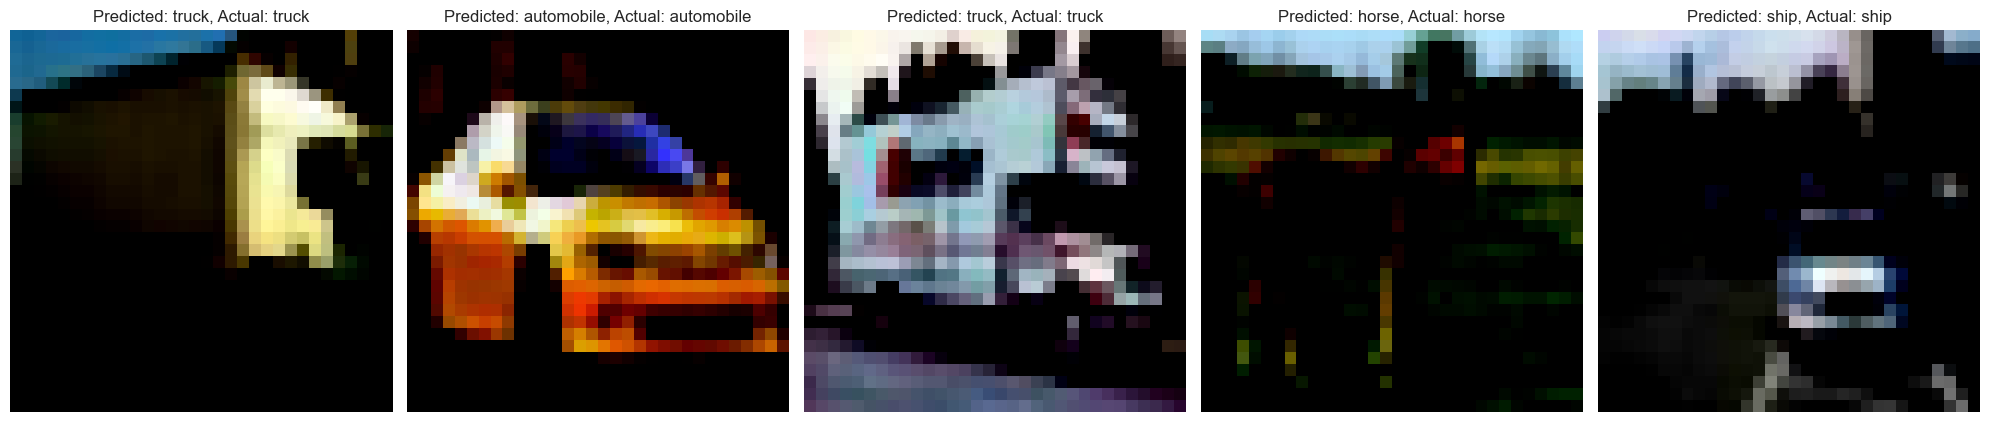

In [51]:
# plot some images from the test set and show the predicted labels
random_indices = np.random.randint(0, len(test_dataset), size=5)
images = []
labels = []
for i in random_indices:
    images.append(test_dataset[i][0])
    labels.append(test_dataset.classes[test_dataset[i][1]])

images = torch.stack(images)
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)
predicted_labels = [test_dataset.classes[i] for i in predicted]

fig, axes = plt.subplots(1, 5, figsize=(20, 20))
axes = axes.flatten()
for img, ax, label in zip(images, axes, predicted_labels):
    ax.imshow(img.cpu().permute(1, 2, 0))
    ax.set_title("Predicted: {}, Actual: {}".format(label, label))
    ax.axis('off')
plt.tight_layout()
plt.show()

# Questions

##**Question:** 

Explain the importance of the positional embedding in the ViT model.

**Your answer:**
Positional embeddings play an important role in the ViT (Vision Transformer) model. In ViT, images are divided into small patches and then fed into the model. The patches are treated as sequences and fed into the transformer-based architecture.

However, the order of the patches in the sequence matters as it carries information about the spatial arrangement of the patches in the image. The positional embeddings allow the model to capture this information and to be aware of the relative position of the patches in the image.

By adding positional embeddings to the patches, the model can learn to differentiate between patches that are close to each other and patches that are far apart, which helps the model understand the spatial relationships between the patches and the overall structure of the image.

In summary, **positional embeddings are important in the ViT model as they allow the model to capture information about the spatial arrangement of patches in an image, which is crucial for image understanding tasks.**

##**Question:** 

How would you evaluate the model if the number of samples per class would not be balanced?
How can you deal with class imbalance on multiclass classification?

**Your answer:**

Evaluating a model with imbalanced class distributions can be challenging, as accuracy may not be a good indicator of performance. There are several metrics that can help better evaluate a model in the presence of class imbalance, including:

Confusion Matrix: A confusion matrix provides a detailed view of the true positive, false positive, true negative, and false negative predictions. It can be used to compute metrics such as precision, recall, and F1-score, which provide more insight into the performance of the model.

Precision, Recall and F1-score: Precision is the fraction of positive predictions that are actually correct, while recall is the fraction of actual positive instances that are correctly predicted. The F1-score is a harmonic mean of precision and recall and provides a balance between them.

AUC-ROC Curve: The receiver operating characteristic (ROC) curve plots the true positive rate against the false positive rate for a binary classifier. The area under the curve (AUC) is a measure of the classifier's performance, with a value of 1.0 indicating a perfect classifier, and a value of 0.5 indicating a random classifier.



To handle class imbalance in multiclass classification, there are several techniques that can be used, including:

Resampling: Resampling can be used to balance the class distributions by either oversampling the minority class or undersampling the majority class.

Cost-sensitive learning: Cost-sensitive learning assigns different costs to different types of errors, allowing the model to prioritize the minority class.

Model ensembles: Model ensembles can be used to combine the predictions of several models, each trained on a different subset of the data. This can help reduce the impact of class imbalance.

Synthetic data generation: Synthetic data generation techniques such as SMOTE (Synthetic Minority Over-sampling Technique) can be used to generate new synthetic samples for the minority class, helping to balance the class distributions.